<a id='top'></a>
# Get Images from the PS1 Image Server

The PanStarrs survey has imaged the entire night sky north of -30$^{\circ}$. Although this makes makes it useful for many kinds of work, you may want to focus on one particular target or region. You might do this using the [PS1 image cutout web interface](http://ps1images.stsci.edu/cgi-bin/ps1cutouts). If you have many targets, a programmatic query would be better for this.

This tutorial will demonstrate a way you can interface with the image server programmatically. To accomplish this, we'll follow this step-by-step workflow:

* [Request a list of Available Images at Our Target Coordinates](#imlist)
* [Generate the Image URL from the Filename](#imurl)
* [Download the Images](#download)
    * [JPEG Images: Monochrome and Color](#jpeg)
    * [FITS Images](#fits)

For more details on the services being used, see the <a href="https://outerspace.stsci.edu/x/ioOc">PS1 Image Cutout Service documentation</a>.

### Imports
We'll need to import a few packages to run our code.
* `requests`, `io`, and `PIL` to request and read JPG images from the image server
* `astropy` to read and visualize FITS files

In [1]:
import matplotlib.pyplot as plt
import numpy
import requests
import warnings

from astropy.io import fits
from astropy.visualization import PercentileInterval, AsinhStretch
from astropy.table import Table
from io import BytesIO
from PIL import Image

<a id='imlist'></a>
## Getting a List of Images
Before we download any images, we should query for a list of observations that include our target. In this case, we're looking for the Crab Nebula, so we'll need to input the corresponding coordinates.

To make this task a little easier, we'll create a helper function called `get_image_table()` that takes in our coordinates and returns a table of results. To do this, we are essentially generating a URL with our query embedded, then reading the resulting webpage.

In [2]:
def get_image_table(ra,dec,filters="grizy"):
    """
    Query ps1filenames.py service to get a list of images
    
    ra, dec = position in degrees
    filters = string with filters to include. includes all by default
    Returns a table with the results
    """
    service = "https://ps1images.stsci.edu/cgi-bin/ps1filenames.py"
    # The final URL appends our query to the PS1 image service
    url = f"{service}?ra={ra}&dec={dec}&filters={filters}"
    # Read the ASCII table returned by the url
    table = Table.read(url, format='ascii')
    return table

With the helper function defined, it's now straightforward to execute our query.

In [3]:
# Crab Nebula Coordinates
ra = 83.633210
dec = 22.014460

# Call our helper function
get_image_table(ra,dec)

projcell,subcell,ra,dec,filter,mjd,type,filename,shortname,badflag
int64,int64,float64,float64,str1,float64,str5,str70,str43,int64
1784,59,83.63321,22.01446,g,0.0,stack,/rings.v3.skycell/1784/059/rings.v3.skycell.1784.059.stk.g.unconv.fits,rings.v3.skycell.1784.059.stk.g.unconv.fits,0
1784,59,83.63321,22.01446,i,0.0,stack,/rings.v3.skycell/1784/059/rings.v3.skycell.1784.059.stk.i.unconv.fits,rings.v3.skycell.1784.059.stk.i.unconv.fits,0
1784,59,83.63321,22.01446,r,0.0,stack,/rings.v3.skycell/1784/059/rings.v3.skycell.1784.059.stk.r.unconv.fits,rings.v3.skycell.1784.059.stk.r.unconv.fits,0
1784,59,83.63321,22.01446,y,0.0,stack,/rings.v3.skycell/1784/059/rings.v3.skycell.1784.059.stk.y.unconv.fits,rings.v3.skycell.1784.059.stk.y.unconv.fits,0
1784,59,83.63321,22.01446,z,0.0,stack,/rings.v3.skycell/1784/059/rings.v3.skycell.1784.059.stk.z.unconv.fits,rings.v3.skycell.1784.059.stk.z.unconv.fits,0


Under the filter column, you'll notice that there are five available options. These five filters are often identified as "grizy" in the PanStarrs literature. By default, our `getimages()` function returns all available filters unless others are specified.

<a id='imurl'></a>
## Getting the Image URL
You can request JPEG, PNG, or FITS images from the service. As before, doing so requires correctly formatting a URL and parsing the response. 

We can create a fairly sophisticated helper function to generate the URLs for us. We'll set our parameters to be the target coordinates, desired image size and format, PanStarrs filters, and whether we'd like a color image. This will result in a lengthy block of code, especially if we check for formatting errors, but it will be flexible enough to handle many varieties of image requests.

**Note:** you can make this function much simpler by removing the error handling. However, it is usually harder to diagnose 'invalid request' errors from the PS1 server than these customized error messages.

In [4]:
def get_imurl(ra, dec, size=240, output_size=None, filters="grizy", im_format="jpg", color=False):
    """
    Get URL for images in the table
    
    ra, dec = position in degrees
    size = extracted image size in pixels (0.25 arcsec/pixel)
    output_size = output (display) image size in pixels (default = size).
                  output_size has no effect for fits format images.
    filters = string with filters to include. choose from "grizy"
    format = data format (options are "jpg", "png" or "fits")
    color = if True, creates a color image (only for jpg or png format).
            Default is return a list of URLs for single-filter grayscale images.   
    Returns a string with the URL
    """
    # Check for user input errors
    if color and (im_format == "fits"):
        raise ValueError("color images are available only for jpg or png formats")
    if im_format not in ("jpg","png","fits"):
        raise ValueError("format must be one of jpg, png, fits")
        
    # Call the original helper function to get the table
    table = get_image_table(ra,dec,filters=filters)
    url = (f"https://ps1images.stsci.edu/cgi-bin/fitscut.cgi?"
           f"ra={ra}&dec={dec}&size={size}&format={im_format}")
    
    # Append an output size, if requested
    if output_size:
        url = url + f"&output_size={output_size}"
        
    # Sort filters from red to blue
    flist = ["yzirg".find(x) for x in table['filter']]
    table = table[numpy.argsort(flist)]
    
    if color:
        # We need at least 3 filters to create a color image
        if len(table) < 3:
            raise ValueError("at least three filters are required for an RGB color image")
        # If more than 3 filters, pick 3 filters from the availble results
        if len(table) > 3:
            table = table[[0,len(table)//2,len(table)-1]]
        # Create the red, green, and blue files for our image
        for i, param in enumerate(["red","green","blue"]):
            url = url + f"&{param}={table['filename'][i]}"
   
    else:
        # If not a color image, only one filter should be given.
        if len(table)>1:
            warnings.warn('Too many filters for monochrome image. Using only 1st filter.')
        # Use red for monochrome images
        urlbase = url + "&red="
        url = []
        filename = table[0]['filename']
        url = urlbase+filename
    return url

Phew! That's a long function. Let's run a little sanity check below.

In [5]:
get_imurl(ra, dec, im_format='png', filters='y', color=False)

'https://ps1images.stsci.edu/cgi-bin/fitscut.cgi?ra=83.63321&dec=22.01446&size=240&format=png&red=/rings.v3.skycell/1784/059/rings.v3.skycell.1784.059.stk.y.unconv.fits'

Looks great! We expected a URL containing our query parameters, and that's exactly what was returned.

Evidently, this is **not** something you want to generate by hand. Although it's harder to set up this helper function initially, it is easy to generate many such URLs for multiple targets of interest.

<a id='download'></a>
## Downloading an Image

Now that we have the image URL, we can get the image itself. FITS files require a little more effort than standard image files to process, but we can write our last helper function to handle that for us.



In [6]:
def get_im(ra, dec, size=240, output_size=None, filters="g", im_format="jpg", color=False):
    """
    Get image at a sky position. Depends on get_imurl
    
    ra, dec = position in degrees
    size = extracted image size in pixels (0.25 arcsec/pixel)
    output_size = output (display) image size in pixels (default = size).
                  output_size has no effect for fits format images.
    filters = string with filters to include
    format = data format (options are "jpg", "png")
    Returns the image
    """
    # For either format, we need the image URL
    url = get_imurl(ra,dec,size=size,filters=filters,output_size=output_size,im_format=im_format,color=color)
    if im_format == "fits":
        fh = fits.open(url)
        # The image is contained within the data unit
        fits_im = fh[0].data
        # Set contrast to something reasonable
        transform = AsinhStretch() + PercentileInterval(99.5)
        im = transform(fits_im)
    else:
        # JPEG is easy. Request the file, read the bytes
        r = requests.get(url)
        im = Image.open(BytesIO(r.content))
    return im

Done! We'll test out this function in the next section.

<a id='jpeg'></a>
### JPEG Images: Monochrome and Color

Let's try getting two images of the Crab Nebula: a single-band grayscale JPEG and color JPEG. We'll set the extracted region size as 1500 pixels = 375 arcsec. This should give us a good view of the Nebula.

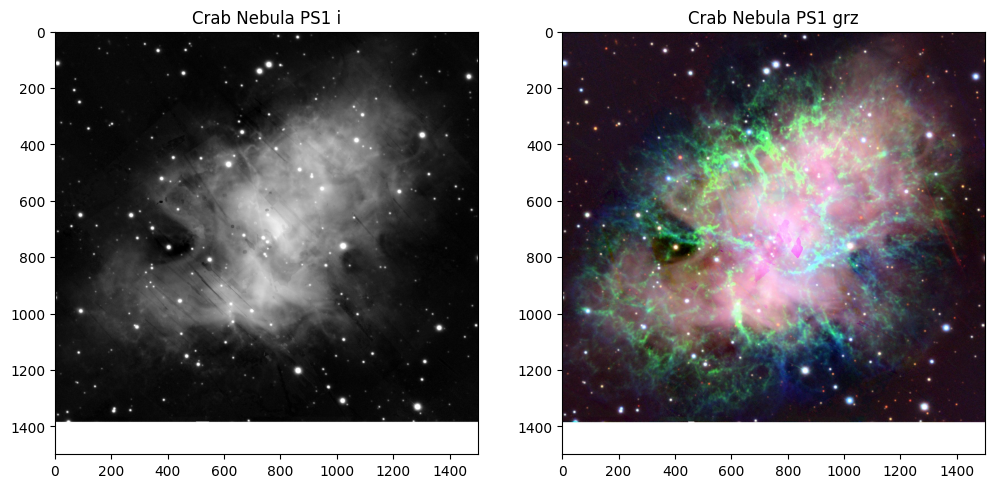

In [7]:
# Set image size
size = 1500

# Greyscale image
gim = get_im(ra, dec, size=size, im_format='jpg', filters="i", color=False)
# Color image
cim = get_im(ra, dec, size=size, im_format='jpg', filters="grz", color=True)

# Create the figure
plt.figure(1,(12,6))

# Grey image subplot on left
plt.subplot(121)
plt.imshow(gim,origin="upper",cmap="gray")
plt.title('Crab Nebula PS1 i')

# Color image subplot on right
plt.subplot(122)
plt.title('Crab Nebula PS1 grz')
plt.imshow(cim,origin="upper")

Whoops! Looks like our image runs off the edge of a [Skycell](https://outerspace.stsci.edu/display/PANSTARRS/PS1+Sky+tessellation+patterns). Our image was a little bit too large, which is what creates the white band at the bottom; there's no data to display.

Other than the image size, this is a good example of how you might process data into both greyscale and color images.

<a id='fits'></a>
### Load and display a FITS image

Let's display a FITS image in the i-band to see if there are any differences from the JPEG version.

Text(0.5, 1.0, 'Crab Nebula PS1 i (fits)')

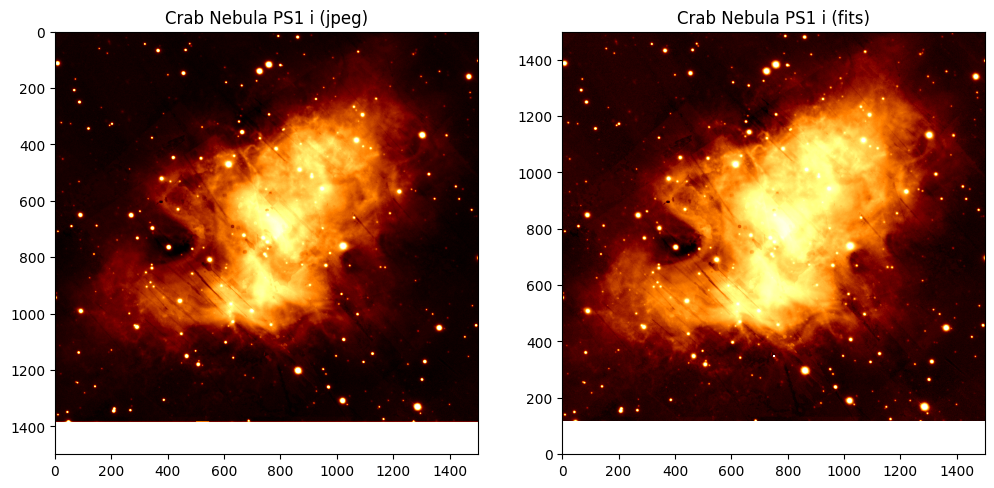

In [8]:
# Get a new fits image in the 'i' band
fitsim = get_im(ra, dec, size=size, filters="i", im_format="fits")

plt.figure(1,(12,6))
# As before, plot the grayscale JPG on the left
plt.subplot(121)
plt.imshow(gim, origin="upper",cmap='afmhot')
plt.title('Crab Nebula PS1 i (jpeg)')

# Now plot the greyscale FITS on the right
plt.subplot(122)
plt.imshow(fitsim, origin="lower", cmap='afmhot')
plt.title('Crab Nebula PS1 i (fits)')

Note that the $y$-axis is flipped in FITS image, compared to the JPEG image. You may actually prefer this, since it matches a typical $x$-$y$ coordinate system.

Another subtle difference you might notice is the contrast in the images. The JPEG image is "dimmer" and does not look as saturated. We hard-coded the contrast for the FITS in our `get_im` function. Did we choose a reasonable value? Feel free to experiment.

## About this Notebook
This notebook was developed by Rick White. Additional editing was provided by Thomas Dutkiewicz.

**Last updated:** Jan 2022 <br>

For support, please contact the Archive HelpDesk at archive@stsci.edu.

***
 <img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/>

[Return to top of page](#top)